# Import Libraries

In [42]:
import zipfile
import re
import os
import json
import math
import numpy as np
import pandas as pd
import datetime as dt
import zipfile
import matplotlib.pyplot as plt
import random
import seaborn as sns

# Unzip files

### Unzip for Mousemovement data

In [43]:
# Define the zip file and destination folder
zip_path = r'data/interim/mousemovement_data.zip'  
extract_folder = "data/interim/mousemovement_data/"  

# Unzip the folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Extracted to {extract_folder}")

Extracted to data/interim/mousemovement_data/


### Unzip for Web log data

In [44]:
# Define the zip file and destination folder
zip_path = r'data/interim/weblog_data.zip'  
extract_folder = "data/interim/weblog_data/"  

# Unzip the folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Extracted to {extract_folder}")

Extracted to data/interim/weblog_data/


# Analysis for Mousemovement data

In [45]:
# read in mouse movement data
mousemovement_data = pd.read_csv(r'data/interim/mousemovement_data/mousemovement_data.csv')

## Mouse movement features

In [46]:
def calculate_all_features(df):
    all_features = {}

    for session, group in df.groupby('session_id'):
        group = group.sort_values('mousemove_times')

        coords = []
        times = []

        for i, row in group.iterrows():
            behavior = row['mousemove_behaviour']
            if isinstance(behavior, str) and '(' in behavior and ',' in behavior:
                try:
                    x = int(behavior.split('(')[1].split(',')[0])
                    y = int(behavior.split(',')[1].split(')')[0])
                    coords.append((x, y))
                    times.append(row['mousemove_times'])
                except (IndexError, ValueError):
                    continue

        if len(coords) < 3:
            continue

        features = {}

        # ----- 1. Movement Speed Variability ----- #
        speeds = []
        for i in range(1, len(coords)):
            dx = coords[i][0] - coords[i - 1][0]
            dy = coords[i][1] - coords[i - 1][1]
            distance = (dx**2 + dy**2)**0.5
            time_diff = (times[i] - times[i - 1]) / 1000

            if time_diff > 0:
                speed = distance / time_diff
                if speed < 5000:
                    speeds.append(speed)

        if speeds:
            mean_speed = sum(speeds) / len(speeds)
            std_speed = (sum((s - mean_speed)**2 for s in speeds) / len(speeds))**0.5
            features['speed_cv'] = std_speed / mean_speed if mean_speed > 0 else 0
        else:
            features['speed_cv'] = None

        # ----- 2. Cursor Hover Patterns ----- #
        hover_radius = 25
        min_hover_time = 300

        hover_events = []
        hover_durations = []

        current_hover_start = 0
        current_hover_center = None

        for i in range(1, len(coords)):
            if current_hover_center is None:
                current_hover_center = coords[i - 1]
                current_hover_start = times[i - 1]

            dx = coords[i][0] - current_hover_center[0]
            dy = coords[i][1] - current_hover_center[1]
            distance = (dx**2 + dy**2)**0.5

            if distance > hover_radius:
                hover_duration = times[i - 1] - current_hover_start
                if hover_duration >= min_hover_time:
                    hover_events.append(current_hover_center)
                    hover_durations.append(hover_duration)

                current_hover_center = coords[i]
                current_hover_start = times[i]

        if current_hover_center is not None:
            hover_duration = times[-1] - current_hover_start
            if hover_duration >= min_hover_time:
                hover_events.append(current_hover_center)
                hover_durations.append(hover_duration)

        features['hover_frequency'] = len(hover_events) / (len(coords) / 100) if len(coords) > 0 else 0
        features['avg_hover_duration'] = sum(hover_durations) / len(hover_durations) if hover_durations else 0


        # ----- 4. Acceleration Profile ----- #
        accelerations = []
        for i in range(1, len(speeds)):
            speed_diff = speeds[i] - speeds[i - 1]
            time_diff = (times[i] - times[i - 2]) / 1000

            if time_diff > 0:
                acceleration = speed_diff / time_diff
                if -10000 < acceleration < 10000:
                    accelerations.append(acceleration)

        if accelerations:
            mean_acc = sum(accelerations) / len(accelerations)
            std_acc = (sum((a - mean_acc)**2 for a in accelerations) / len(accelerations))**0.5
            skewness = sum(((a - mean_acc) / std_acc)**3 for a in accelerations) / len(accelerations) if std_acc > 0 else 0
            pos_acc = sum(1 for a in accelerations if a > 0)
            neg_acc = sum(1 for a in accelerations if a < 0)
            pos_neg_ratio = pos_acc / neg_acc if neg_acc > 0 else float('inf')

            features['acceleration_mean'] = mean_acc
            features['acceleration_std'] = std_acc
            features['acceleration_skewness'] = skewness
            features['acceleration_pos_neg_ratio'] = pos_neg_ratio
        else:
            features['acceleration_mean'] = None
            features['acceleration_std'] = None
            features['acceleration_skewness'] = None
            features['acceleration_pos_neg_ratio'] = None

        # ----- 5. Direction Change Frequency ----- #
        angle_threshold = 45
        direction_changes = 0

        for i in range(2, len(coords)):
            v1 = (coords[i - 1][0] - coords[i - 2][0], coords[i - 1][1] - coords[i - 2][1])
            v2 = (coords[i][0] - coords[i - 1][0], coords[i][1] - coords[i - 1][1])

            mag_v1 = (v1[0]**2 + v1[1]**2)**0.5
            mag_v2 = (v2[0]**2 + v2[1]**2)**0.5

            if mag_v1 > 0 and mag_v2 > 0:
                dot_product = v1[0]*v2[0] + v1[1]*v2[1]
                cos_angle = max(min(dot_product / (mag_v1 * mag_v2), 1.0), -1.0)
                angle = math.degrees(math.acos(cos_angle))
                if angle > angle_threshold:
                    direction_changes += 1

        total_distance = 0
        for i in range(1, len(coords)):
            dx = coords[i][0] - coords[i - 1][0]
            dy = coords[i][1] - coords[i - 1][1]
            total_distance += (dx**2 + dy**2)**0.5

        features['direction_change_frequency'] = direction_changes / (total_distance / 100) if total_distance > 0 else 0

        # ----- 6. Idle-to-Active Time Ratio ----- #
        idle_threshold = 500
        idle_time = 0
        active_time = 0

        for i in range(1, len(times)):
            time_diff = times[i] - times[i - 1]
            if time_diff > idle_threshold:
                idle_time += time_diff
            else:
                active_time += time_diff

        features['idle_active_ratio'] = idle_time / active_time if active_time > 0 else float('inf')

        # Store features
        all_features[session] = features

    return all_features

In [47]:
features = calculate_all_features(mousemovement_data)

features_df = pd.DataFrame.from_dict(features, orient='index').reset_index().rename(columns={'index': 'session_id'})

# Get session-wise labels from the original df
session_labels = mousemovement_data[['session_id', 'label']].drop_duplicates(subset='session_id')

# Merge labels into features_df
features_df = features_df.merge(session_labels, on='session_id', how='left')


Plot boxplot of the different features generated

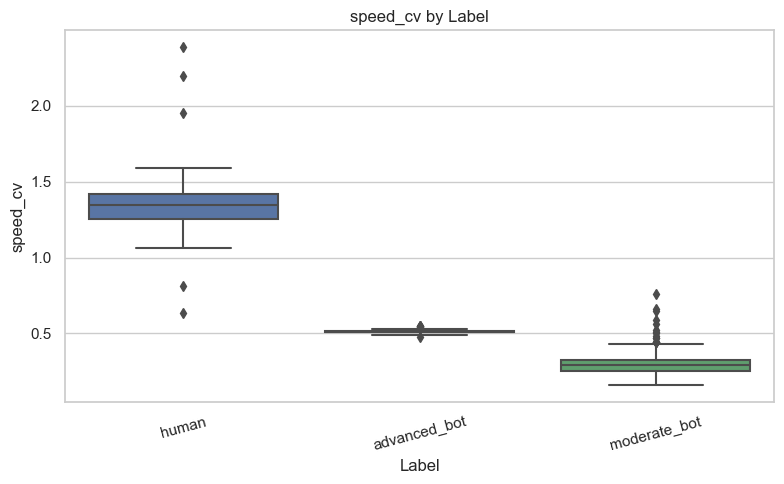

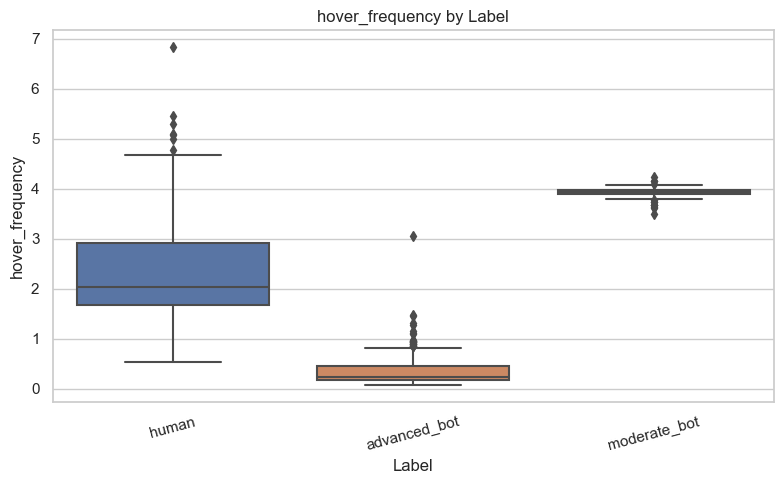

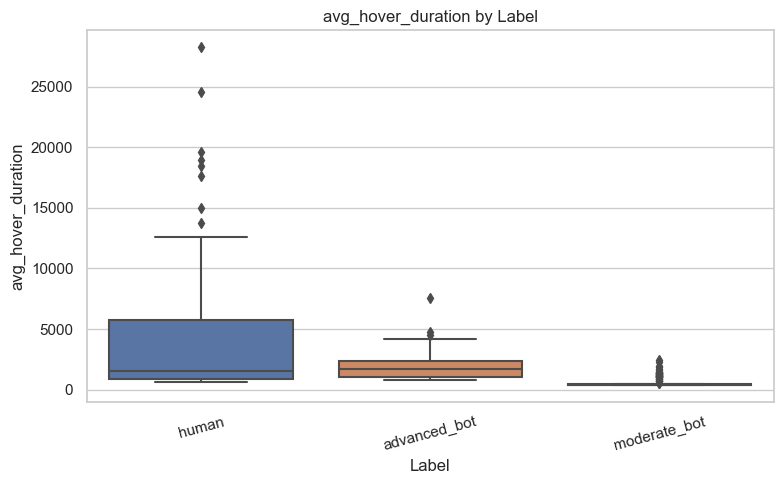

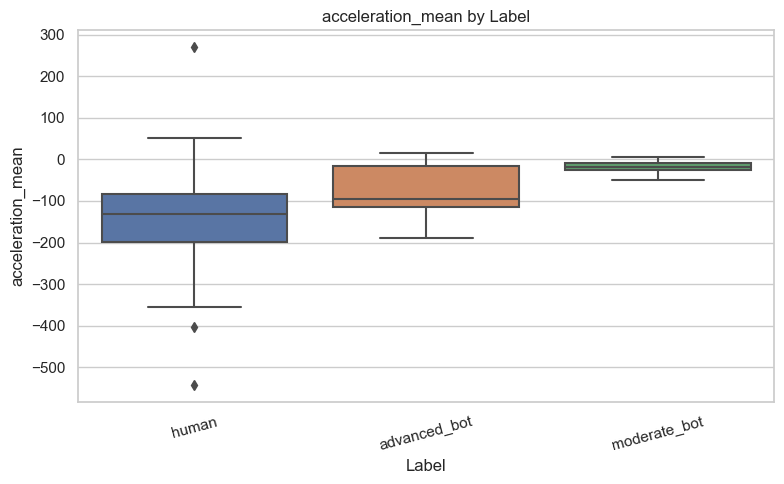

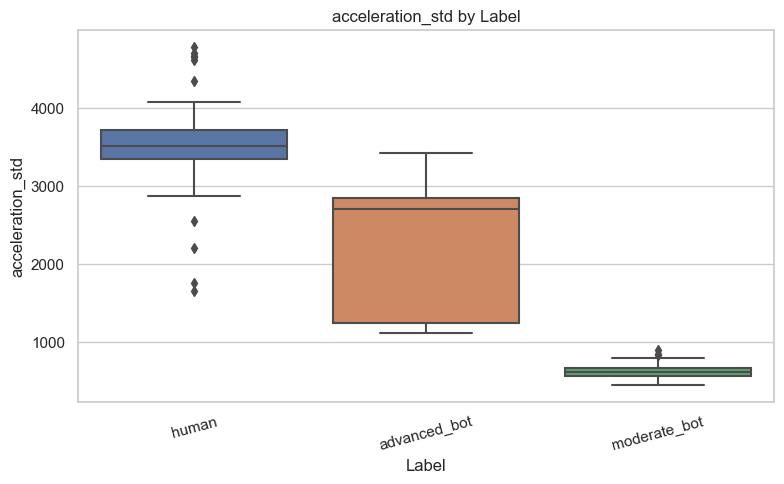

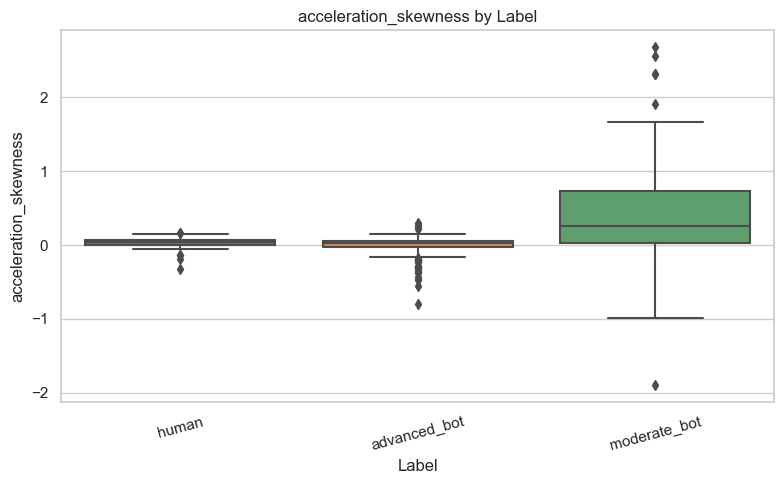

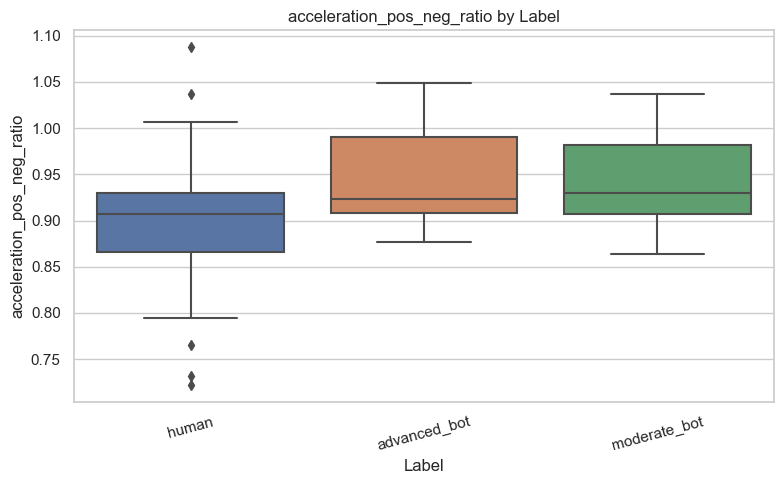

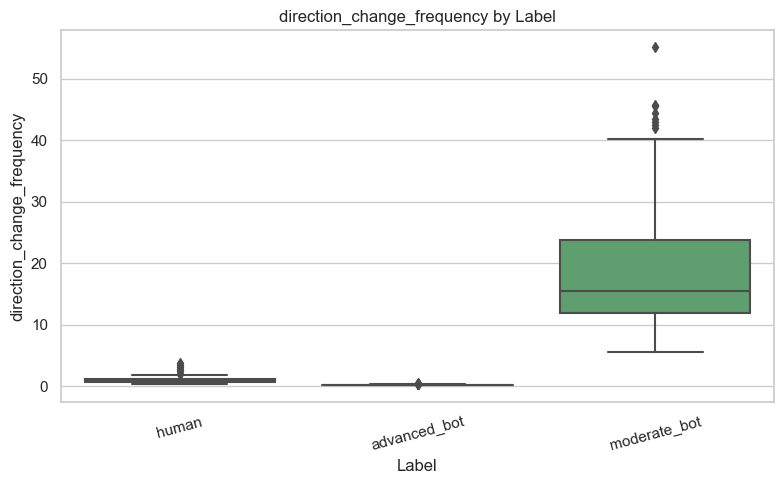

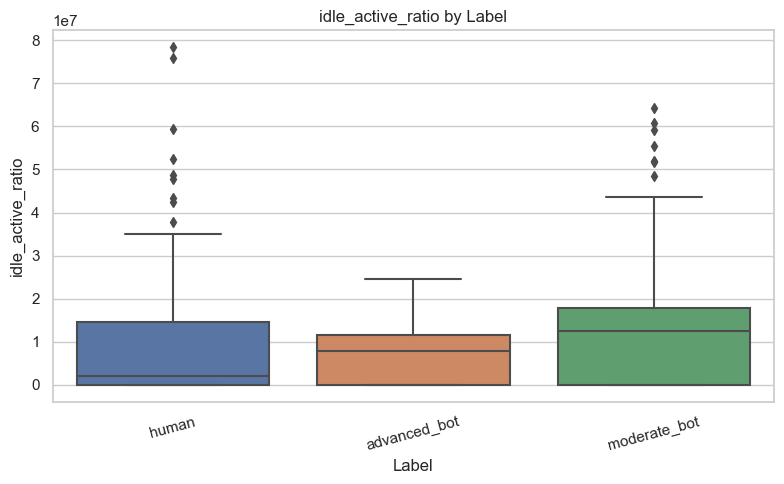

In [48]:
# Set style
sns.set(style="whitegrid")

# List of metrics (excluding session_id and label)
metric_columns = [
    'speed_cv', 'hover_frequency', 'avg_hover_duration',
    'acceleration_mean', 'acceleration_std', 'acceleration_skewness',
    'acceleration_pos_neg_ratio', 'direction_change_frequency',
    'idle_active_ratio'
]

# Plot each metric by label
for metric in metric_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='label', y=metric, data=features_df)
    plt.title(f'{metric} by Label')
    plt.xlabel('Label')
    plt.ylabel(metric)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()


## Mouse click features

### Sessions and click frequency

In [49]:
analyse_mouse_clicks = mousemovement_data.copy()

# Sort values
analyse_mouse_clicks = analyse_mouse_clicks.sort_values(by=['session_id', 'mousemove_times']).reset_index(drop=True)

# Extract the mousemove_x and mousemove_y coordinates from the 'mousemove_behaviour' string column
analyse_mouse_clicks[['mousemove_x', 'mousemove_y']] = analyse_mouse_clicks['mousemove_behaviour'].str.replace(r'[()]', '', regex=True).str.split(',', expand=True)

# Convert mousemove_x and mousemove_y to integer type
analyse_mouse_clicks['mousemove_x'] = analyse_mouse_clicks['mousemove_x'].astype(int)
analyse_mouse_clicks['mousemove_y'] = analyse_mouse_clicks['mousemove_y'].astype(int)

# Define custom order for results display
custom_order = ['moderate_bot', 'advanced_bot', 'human']

In [50]:
# See movement types
analyse_mouse_clicks['mousemove_type'].value_counts()

m     3631516
cl       8759
cr        160
cm         64
Name: mousemove_type, dtype: int64

In [51]:
summary_data = []

df_sessions = analyse_mouse_clicks.copy()
df_sessions['session_max_time'] = df_sessions.groupby('session_id')['mousemove_times'].transform('max')
df_sessions['session_min_time'] = df_sessions.groupby('session_id')['mousemove_times'].transform('min')
df_sessions['durations'] = df_sessions['session_max_time'] - df_sessions['session_min_time']

for label, group in df_sessions.groupby('label'):
    
    # Count the number of sessions
    unique_sessions = group['session_id'].nunique()

    # Count the total duration of all sessions
    total_duration = group['durations'].sum()

    # Filter for clicks and count the number of clicks
    filtered_group = group[group['mousemove_type'] != 'm']
    total_clicks = len(filtered_group)

    # Add to summary 
    summary_data.append({
        'Label': label,
        'Sessions Count': unique_sessions,
        'Total Duration': total_duration,
        'Total Clicks': total_clicks,
        'Avg Clicks/Session': round(total_clicks / unique_sessions) if unique_sessions > 0 else 0,
        'Click Frequency': total_clicks / total_duration if total_duration > 0 else 0
    })

# Show summary
df_summary = pd.DataFrame(summary_data)
df_summary['Label'] = pd.Categorical(df_summary['Label'], categories=custom_order, ordered=True)
df_summary = df_summary.sort_values('Label')
df_summary

# Humans have higher click frequency than bots 
# Humans have higher average clicks per session than bots

# Features that can be added: duration of session, total number of clicks per session, and click frequency

,Label,Sessions Count,Total Duration,Total Clicks,Avg Clicks/Session,Click Frequency
2,moderate_bot,170,1180641390430763823,2407,14,2.038722e-15
0,advanced_bot,170,1889324586603925859,2483,15,1.314226e-15
1,human,109,998575026196032233,4093,38,4.098841e-15


In [52]:
df_sessions = analyse_mouse_clicks.copy()
# Aggregate session-level metrics
df_sessions = df_sessions.groupby(['session_id','label']).agg(
    session_max_time=('mousemove_times', 'max'),
    session_min_time=('mousemove_times', 'min'),
    clicks_count=('mousemove_type', lambda x: (x != 'm').sum())
).reset_index()

# Calculate session duration
df_sessions['durations'] = df_sessions['session_max_time'] - df_sessions['session_min_time']

# Avoid division by zero and compute click frequency
df_sessions['click_frequency'] = df_sessions['clicks_count'] / df_sessions['durations'].replace(0, np.nan)

df_sessions_csv = df_sessions[['session_id', 'clicks_count', 'durations', 'click_frequency']]

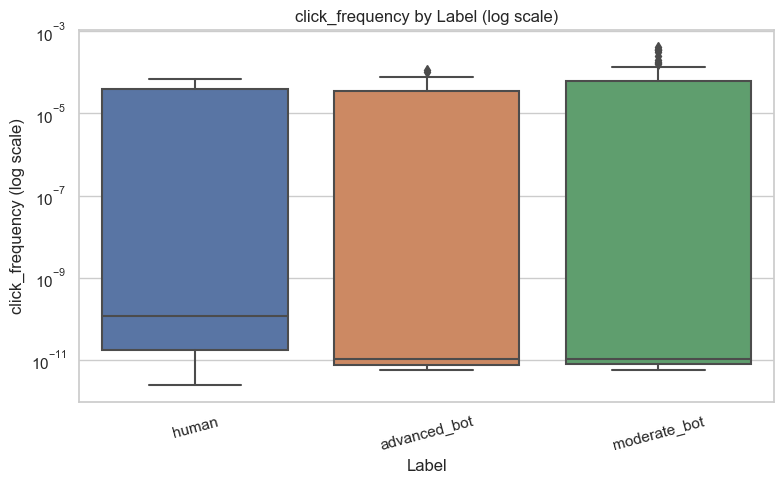

In [53]:
# box plot
plt.figure(figsize=(8, 5))
sns.boxplot(x='label', y='click_frequency', data=df_sessions)
plt.yscale('log')
plt.title(f'click_frequency by Label (log scale)')
plt.xlabel('Label')
plt.ylabel('click_frequency (log scale)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Click coordinates

In [54]:
analyse_mouse_clicks['mousemove_x'].describe().astype(int)
# (0, 2600)

count    3640499
mean         636
std          397
min            0
25%          310
50%          584
75%          940
max         2519
Name: mousemove_x, dtype: int64

In [55]:
analyse_mouse_clicks['mousemove_y'].describe().astype(int)
# (0, 1800)

count    3640499
mean         387
std          162
min            0
25%          267
50%          349
75%          481
max         1775
Name: mousemove_y, dtype: int64

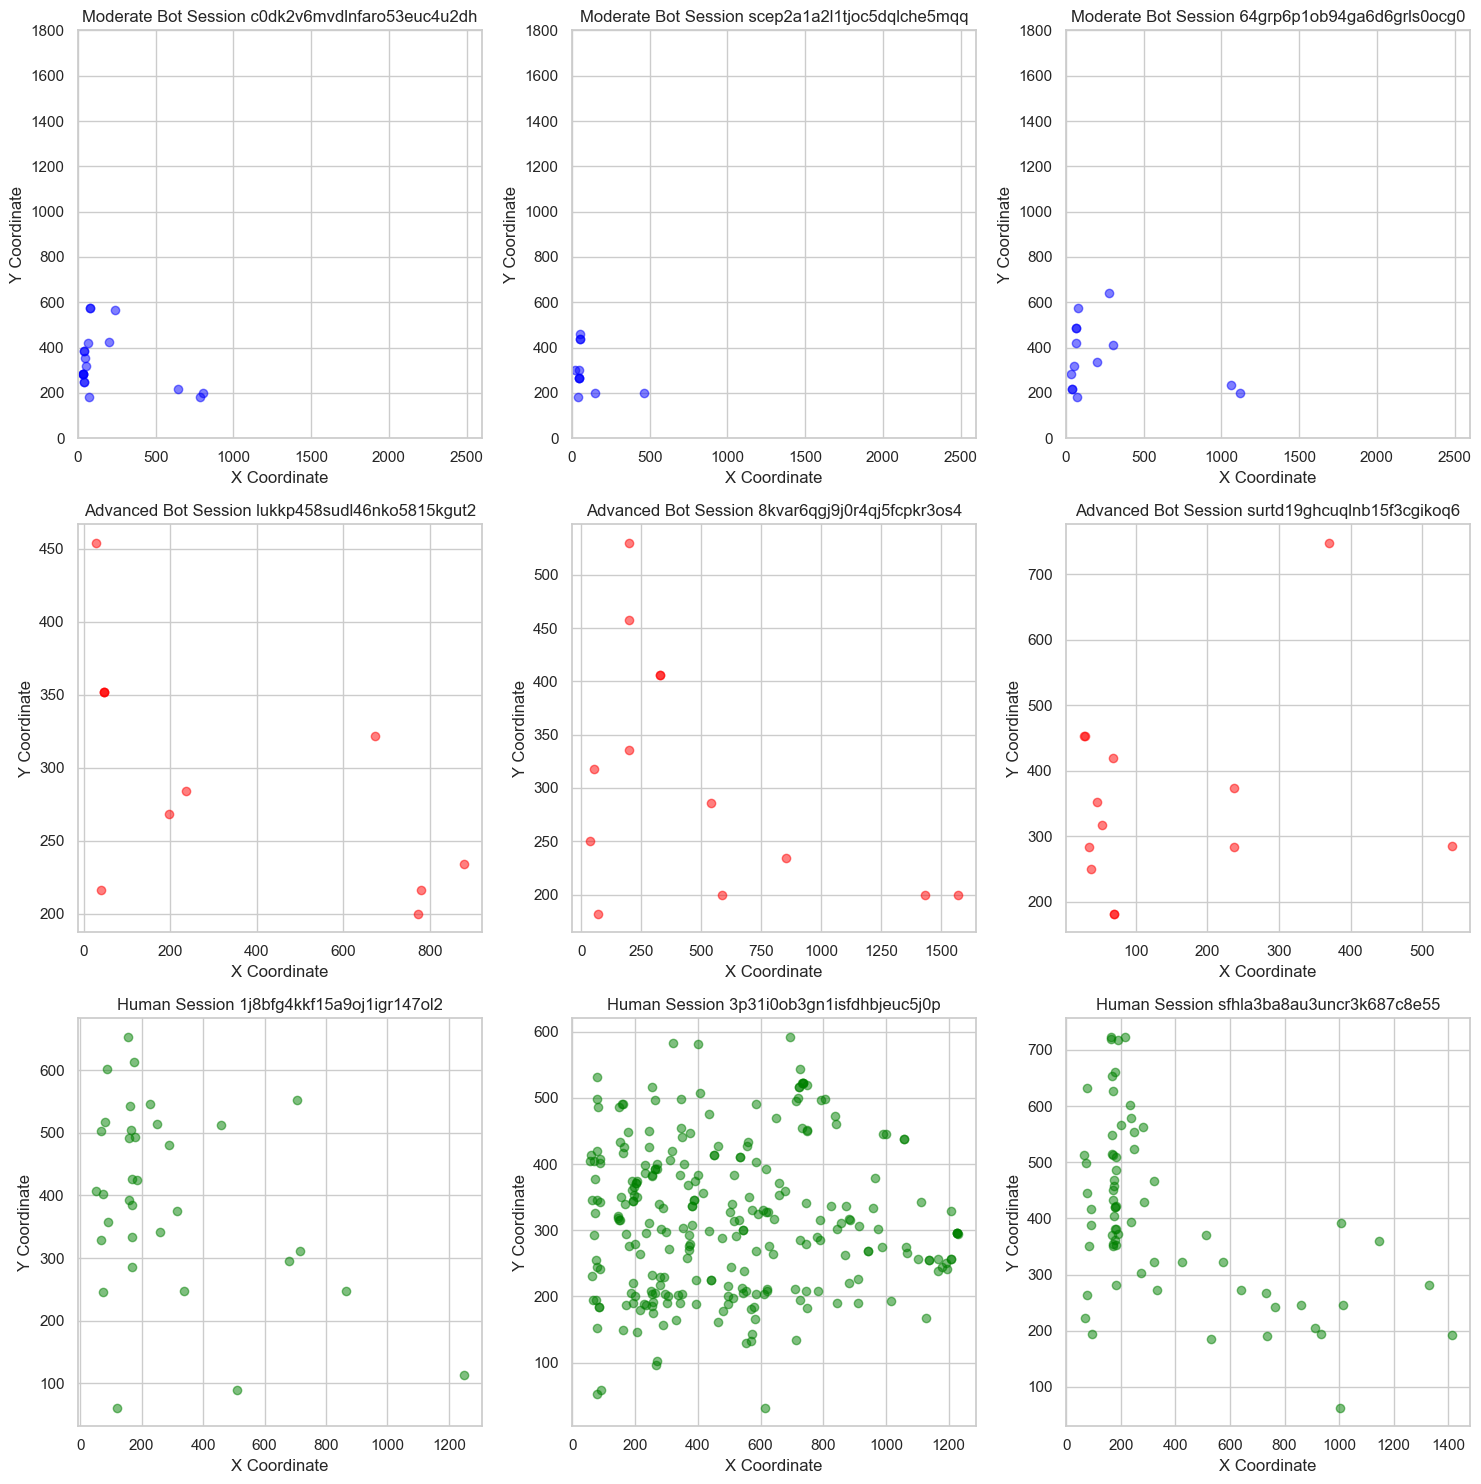

In [56]:
df_clicks = analyse_mouse_clicks[analyse_mouse_clicks['mousemove_type']!='m']

# Separate moderate_bot, advanced_bot, and human data
moderate_bot_data = df_clicks[df_clicks['label'] == 'moderate_bot']
advanced_bot_data = df_clicks[df_clicks['label'] == 'advanced_bot']
human_data = df_clicks[df_clicks['label'] == 'human']

# Randomly select 3 sessions from each group
selected_moderate_bot_sessions = random.sample(list(moderate_bot_data['session_id']), 3)
selected_advanced_bot_sessions = random.sample(list(advanced_bot_data['session_id']), 3)
selected_human_sessions = random.sample(list(human_data['session_id']), 3)

# Set up the plotting area: 3 rows (one for each category) and 3 columns
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Plot for moderate_bot sessions
for i, session in enumerate(selected_moderate_bot_sessions):
    session_data = moderate_bot_data[moderate_bot_data['session_id'] == session]
    axs[0, i].scatter(session_data['mousemove_x'], session_data['mousemove_y'], alpha=0.5, c='blue')
    axs[0, i].set_title(f'Moderate Bot Session {session}')
    axs[0, i].set_xlabel('X Coordinate')
    axs[0, i].set_ylabel('Y Coordinate')
    axs[0, i].set_xlim(0, 2600) 
    axs[0, i].set_ylim(0, 1800) 

# Plot for advanced_bot sessions
for i, session in enumerate(selected_advanced_bot_sessions):
    session_data = advanced_bot_data[advanced_bot_data['session_id'] == session]
    axs[1, i].scatter(session_data['mousemove_x'], session_data['mousemove_y'], alpha=0.5, c='red')
    axs[1, i].set_title(f'Advanced Bot Session {session}')
    axs[1, i].set_xlabel('X Coordinate')
    axs[1, i].set_ylabel('Y Coordinate')
    axs[0, i].set_xlim(0, 2600) 
    axs[0, i].set_ylim(0, 1800) 

# Plot for human sessions
for i, session in enumerate(selected_human_sessions):
    session_data = human_data[human_data['session_id'] == session]
    axs[2, i].scatter(session_data['mousemove_x'], session_data['mousemove_y'], alpha=0.5, c='green')
    axs[2, i].set_title(f'Human Session {session}')
    axs[2, i].set_xlabel('X Coordinate')
    axs[2, i].set_ylabel('Y Coordinate')
    axs[0, i].set_xlim(0, 2600) 
    axs[0, i].set_ylim(0, 1800) 

# Adjust layout
plt.tight_layout()
plt.show()

Analysis of entropy of click coordinates

In [57]:
# Entropy of click coordinates 
df_entropy = df_clicks.copy()

# Define grid size (e.g., 100x100 pixels per grid cell)
grid_size = 100

def calculate_session_entropy(df_entropy, grid_size):
    # Discretize the coordinates into grid cells (vectorized operation)
    df_entropy['mousemove_x'] = df_entropy['mousemove_x'] // grid_size
    df_entropy['mousemove_y'] = df_entropy['mousemove_y'] // grid_size
    
    # Group by session_id and label, calculate frequencies for each session
    grouped = df_entropy.groupby(['session_id', 'label', 'mousemove_x', 'mousemove_y']).size().reset_index(name='count')

    # Calculate total visits per session (needed for probability calculation)
    session_totals = grouped.groupby(['session_id', 'label'])['count'].transform('sum')
    
    # Calculate probabilities
    grouped['probability'] = grouped['count'] / session_totals
    
    # Calculate entropy using Shannon's formula
    grouped['entropy_part'] = -grouped['probability'] * np.log2(grouped['probability'] + np.finfo(float).eps)
    
    # Aggregate entropy for each session_id and label
    entropy_data = grouped.groupby(['session_id', 'label'])['entropy_part'].sum().reset_index(name='entropy')
    
    return entropy_data

# Example usage
session_entropy_df = calculate_session_entropy(df_entropy, grid_size)
session_entropy_df['label'] = pd.Categorical(session_entropy_df['label'], categories=custom_order, ordered=True)
session_entropy_df.groupby('label', observed=True)['entropy'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
moderate_bot,170.0,2.626185,0.332334,1.530493,2.419818,2.646439,2.862950,3.292770
advanced_bot,170.0,2.867802,0.390710,1.676737,2.692381,2.873023,3.180833,3.721612
human,109.0,3.712109,0.761740,2.000000,3.238901,3.572469,4.248495,5.695357


# Analysis for Web log data

In [58]:
# Basic statistics
def analyze_requests(df):
    print("Total Requests:", len(df))
    print("Unique Sessions:", df['session_id'].nunique())
    print("Categories:", df['category'].value_counts())

# Compare humans vs bots
def compare_humans_bots(df):
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    df = df.sort_values(by=['session_id', 'datetime'])
    human_df = df[df['category'] == 'humans']
    bot_df = df[df['category'] == 'bots']
    
    print("\nAverage Requests per Session:")
    print("Humans:", human_df.groupby('session_id').size().mean())
    print("Bots:", bot_df.groupby('session_id').size().mean())

    print("\nAverage Duration Between Requests:")
    human_time_diff = []
    for _, group in human_df.groupby('session_id'):
        time_diff = group['datetime'].diff().dropna()  
        human_time_diff.extend(time_diff)
    bot_time_diff = []
    for _, group in bot_df.groupby('session_id'):
        time_diff = group['datetime'].diff().dropna()  
        bot_time_diff.extend(time_diff)
    print("Humans:", pd.to_timedelta(human_time_diff).mean())
    print("Bots:", pd.to_timedelta(bot_time_diff).mean())

    print("\nRequest Type Distribution:")
    print("Humans:", (human_df['method'].value_counts(normalize=True) * 100).round(2))
    print("Bots:", (bot_df['method'].value_counts(normalize=True) * 100).round(2))

    print("\nReferrer Presence:")
    print("Humans:", (human_df['referrer'].str.strip() != '-').mean())
    print("Bots:", (bot_df['referrer'].str.strip() != '-').mean())

    print("\nStatus Distribution:")
    print("Humans:", (human_df['status'].value_counts(normalize=True) * 100).round(2))
    print("Bots:", (bot_df['status'].value_counts(normalize=True) * 100).round(2))

    for df in [human_df,bot_df]:
        session_requests = df.groupby("session_id").agg(first_request=("datetime", "min"), last_request=("datetime", "max"), total_requests=("datetime", "count"))
        session_requests["session_duration"] = (session_requests["last_request"] - session_requests["first_request"]).dt.total_seconds()
        session_requests["session_duration"].replace(0, 1, inplace=True) # if there is only one request rate
        session_requests["request_rate"] = session_requests["total_requests"] / session_requests["session_duration"]
        avg_session_duration = session_requests["session_duration"].mean()
        avg_request_rate = session_requests["request_rate"].mean()

        if df is human_df:
            avg_session_duration_humans = avg_session_duration
            avg_request_rate_humans = avg_request_rate
            category = "humans"
        else:
            avg_session_duration_bots = avg_session_duration
            avg_request_rate_bots = avg_request_rate
            category = "bots"

        # Distribution of request by time and day
        
        # Extract hour and day of the week
        df["hour"] = df["datetime"].dt.hour
        df["day_of_week"] = df["datetime"].dt.day_name()
        hourly_traffic = df["hour"].value_counts().sort_index()
        daily_traffic = df["day_of_week"].value_counts()

        # Plot Peak Hours
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        hourly_traffic.plot(kind="bar", color="royalblue")
        plt.xlabel("Hour")
        plt.ylabel("Number of Requests")
        plt.title("Traffic by Hour (" + category +")")

        # Plot Peak Days
        plt.subplot(1, 2, 2)
        daily_traffic.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]).plot(kind="bar", color="darkorange")
        plt.xlabel("Day")
        plt.ylabel("Number of Requests")
        plt.title("Traffic by Day (" + category +")")

        plt.tight_layout()
        plt.show()

    print("\nAverage Duration per Session:")
    print("Humans:", avg_session_duration_humans)
    print("Bots:", avg_session_duration_bots)

    print("\nAverage Request Rate:")
    print("Humans:", avg_request_rate_humans)
    print("Bots:", avg_request_rate_bots)

Total Requests: 305372
Unique Sessions: 814
Categories: humans    214175
bots       91197
Name: category, dtype: int64

Average Requests per Session:
Humans: 547.7621483375959
Bots: 214.58117647058825

Average Duration Between Requests:
Humans: 0 days 00:03:49.806491598
Bots: 0 days 00:06:14.717225576

Request Type Distribution:
Humans: POST       93.12
GET         6.57
OPTIONS     0.26
CONNECT     0.04
HEAD        0.00
Name: method, dtype: float64
Bots: POST       85.71
GET        13.60
OPTIONS     0.68
Name: method, dtype: float64

Referrer Presence:
Humans: 0.9727185712618186
Bots: 0.9881355746351306

Status Distribution:
Humans: 200    98.15
404     1.81
400     0.03
304     0.01
408     0.00
403     0.00
Name: status, dtype: float64
Bots: 200    99.98
404     0.02
400     0.00
Name: status, dtype: float64


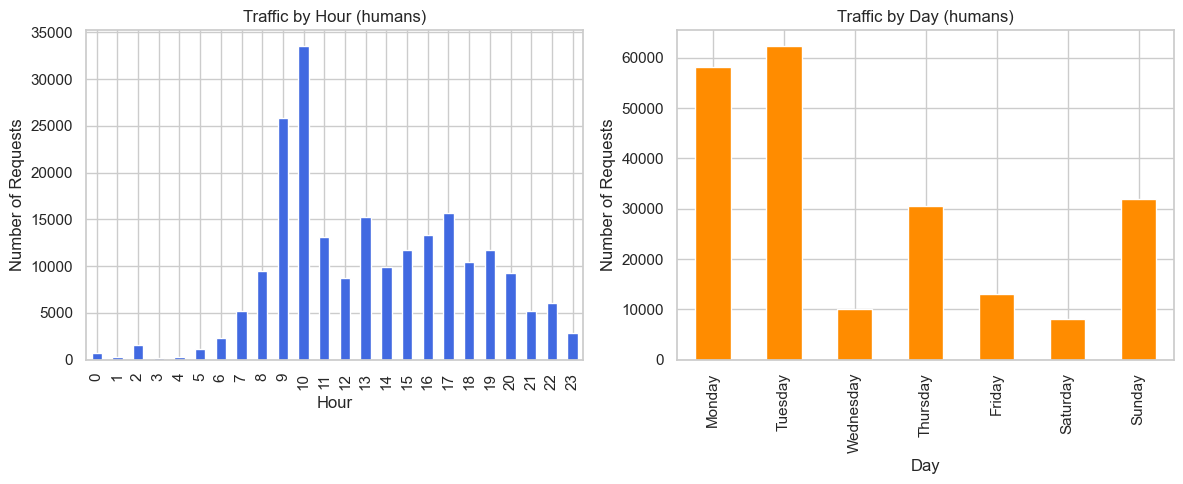

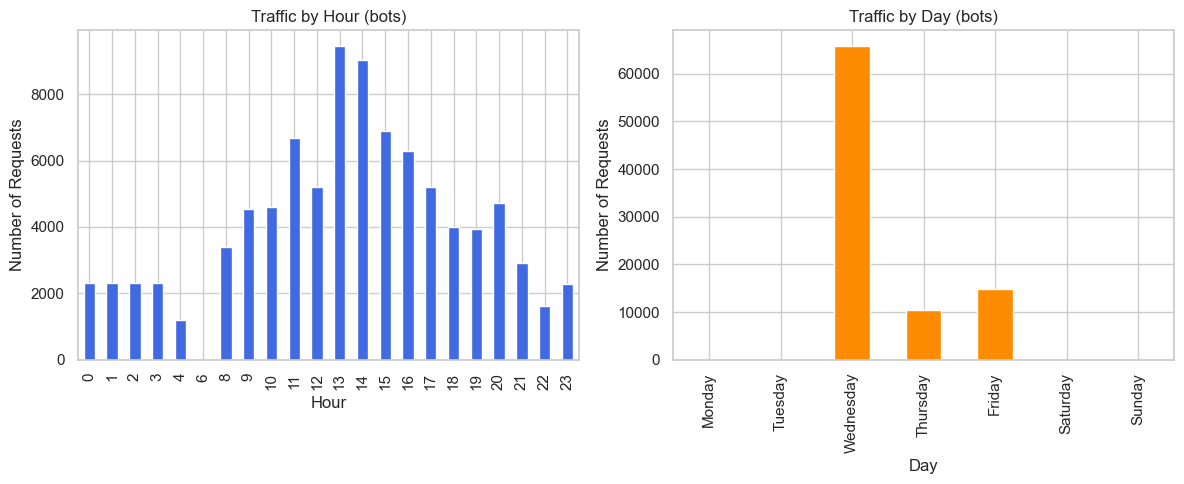


Average Duration per Session:
Humans: 125649.51406649617
Bots: 80032.54588235295

Average Request Rate:
Humans: 1.2074365371234423
Bots: 1.0408043948008479


In [59]:
# Run analysis for web log data
weblog_data_dir = "data/interim/weblog_data/weblog_data.csv"
weblog_data = pd.read_csv(weblog_data_dir, parse_dates=["datetime"])
analyze_requests(weblog_data)
compare_humans_bots(weblog_data)